In [1]:
#DTW calculation

import pandas as pd
import numpy as np
import pickle
from math import *
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
M_PI = 3.14159265358979323846
%matplotlib inline

In [2]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [24]:
def GaussianFilter(df, window_length):
    df1 = df
    
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    df1['AX1'] = gaussian_filter(df['AX1'], window_length)
    df1['AY1'] = gaussian_filter(df['AY1'], window_length)
    df1['AZ1'] = gaussian_filter(df['AZ1'], window_length)

    df1['GX1'] = gaussian_filter(df['GX1'], window_length)
    df1['GY1'] = gaussian_filter(df['GY1'], window_length)
    df1['GZ1'] = gaussian_filter(df['GZ1'], window_length)
    return df1

In [25]:
def Yaw_Roll_Pitch(df):
    roll  = []
    pitch = []
    yaw   = []
    for i in range(len(df)):
        x = df['AX'][i]
        y = df['AY'][i]
        z = df['AZ'][i]
        roll1 = atan(y/z)*57.3
        pitch1= atan((-x/(y*y + z*z)**(1/2)))*57.3
        yaw1  = atan((z/((x*x + z*z)**(1/2))))*57.3
        
        roll.append(roll1)
        pitch.append(pitch1)
        yaw.append(yaw1)
    
    df['pitch'] = pitch
    df['roll'] = roll
    df['yaw'] = yaw

In [26]:
def getQuat(df):

        """ Given 3 orientation angles, compute the quaternion. """

        yaw   = df['yaw'] / 2. * np.pi / 180
        roll  = df['pitch'] / 2. * np.pi / 180
        pitch = df['roll'] / 2. * np.pi / 180

        w =  np.cos(roll) * np.cos(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.sin(pitch) * np.sin(yaw)

        x =  np.sin(roll) * np.cos(pitch) * np.cos(yaw) - \
                np.cos(roll) * np.sin(pitch) * np.sin(yaw)

        y =  np.cos(roll) * np.sin(pitch) * np.cos(yaw) + \
                np.sin(roll) * np.cos(pitch) * np.sin(yaw)

        z =  np.cos(roll) * np.cos(pitch) * np.sin(yaw) - \
                np.sin(roll) * np.sin(pitch) * np.cos(yaw)

        return w, x, y, z

In [27]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX','AX1', 'AY','AY1', 'AZ','AZ1',
                                                      'GX','GX1', 'GY','GY1', 'GZ','GZ1']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))
        ax.grid(True)

In [28]:
"""
Rotate a 3D vector using the axis-angle method (quaternions).
"""

import numpy as np


def normalize(v, tolerance=0.00001):
    mag2 = sum(n * n for n in v)
    if abs(mag2 - 1.0) > tolerance:
        mag = np.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return v

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    return w, x, y, z

def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w) * 2.0
    return normalize(v), theta

In [29]:
def get_rotation(quatern, vector):
    rotaedvector = []
    for i in range(vector.shape[0]):
        rotaedvector.append(qv_mult(tuple(quatern[i,:]), tuple(vector[i,:])))
    return np.array(rotaedvector)

In [30]:
def rotate(df):
    features = ['A', 'G']
    quaternion = df[['quaternionW', 'quaternionX',
                     'quaternionY','quaternionZ']].values
    
    for f in features:
        xyzlist = [f + 'X', f + 'Y', f + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = get_rotation(quaternion, xyz)
        df[f + 'X1'] = xyz_rotated[:,0]
        df[f + 'Y1'] = xyz_rotated[:,1]
        df[f + 'Z1'] = xyz_rotated[:,2]
        

In [31]:
def data_preprocessing(df):
    df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    Yaw_Roll_Pitch(df)
    qw, qx, qy, qz = getQuat(df)
    df['quaternionW'] = qw
    df['quaternionX'] = qx
    df['quaternionY'] = qy
    df['quaternionZ'] = qz
    rotate(df)
    df = GaussianFilter(df, 5)
    return df

In [32]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/Accelerometer.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike = read_csv_file(acc_file, gyro_file, 'bike')

n = len(df_bike)
print("shape -", df_bike.shape)

df_bike = df_bike[1000 : n-1000]

df_bike.reset_index(drop = True, inplace = True)
df = data_preprocessing(df_bike)
print("shape -", df.shape)
df.head()


shape - (14390, 8)
shape - (12390, 21)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,pitch,roll,...,quaternionW,quaternionX,quaternionY,quaternionZ,AX1,AY1,AZ1,GX1,GY1,GZ1
0,20.001,-0.679215,-0.751187,-10.328509,-0.045794,-0.007894,0.566408,bike,7.519719,7.489165,...,0.919116,0.085316,0.035352,-0.383010,-1.064982,0.953264,-10.257849,-0.036168,-0.027769,0.565708
1,20.022,-0.661558,-0.747748,-10.322536,-0.045373,-0.007476,0.564057,bike,1.313942,3.550076,...,0.923254,0.022440,0.024231,-0.382769,-1.059978,0.928475,-10.252920,-0.035166,-0.026920,0.563426
2,20.041,-0.627205,-0.741516,-10.310882,-0.044581,-0.006686,0.559156,bike,6.380384,4.900305,...,0.921283,0.067674,0.018262,-0.382525,-1.050895,0.880234,-10.243229,-0.033249,-0.025271,0.558662
3,20.062,-0.577891,-0.733571,-10.294065,-0.043502,-0.005623,0.551344,bike,3.246722,3.950541,...,0.922730,0.039334,0.021012,-0.382859,-1.039268,0.810965,-10.229076,-0.030589,-0.022922,0.551050
4,20.081,-0.516137,-0.725228,-10.272834,-0.042231,-0.004415,0.540164,bike,5.480695,-0.269144,...,0.923290,0.043295,-0.020415,-0.381110,-1.026978,0.724186,-10.210921,-0.027415,-0.020019,0.540127


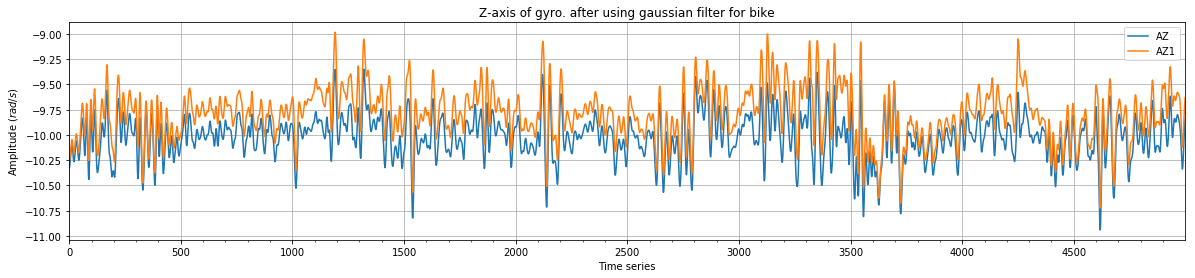

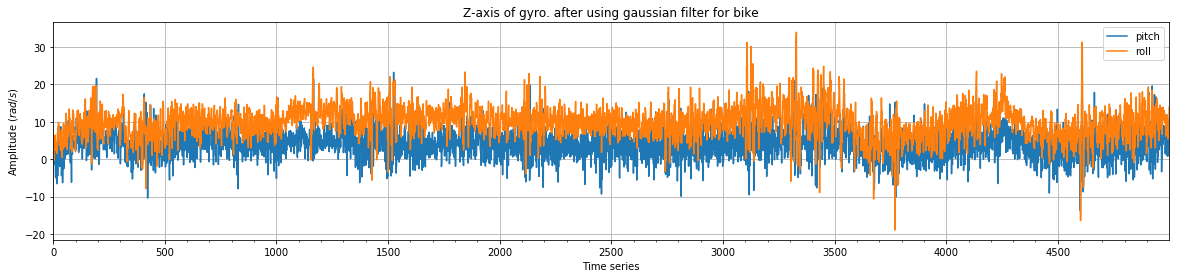

In [33]:
fig, ax = plt.subplots()
m=5000
df[['AZ' ,'AZ1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)
fig, ax = plt.subplots()
m=5000
df[['pitch' ,'roll']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)

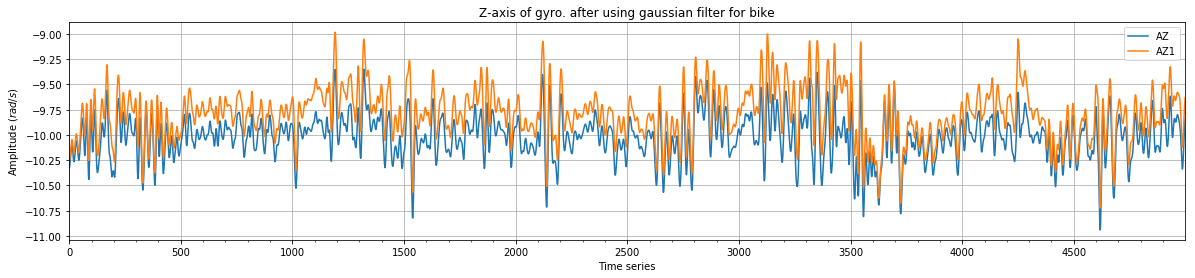

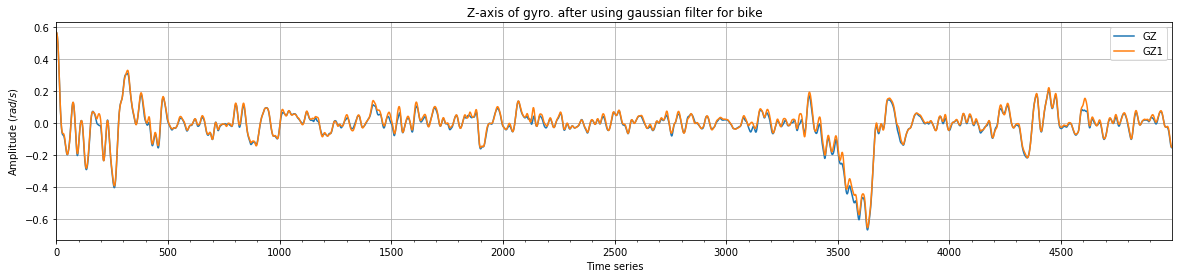

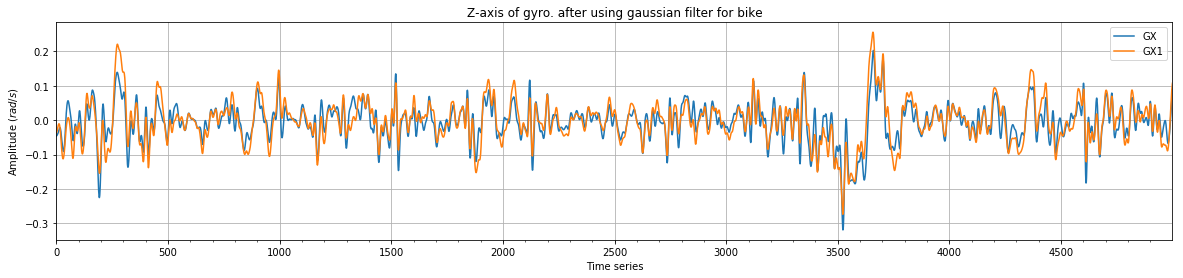

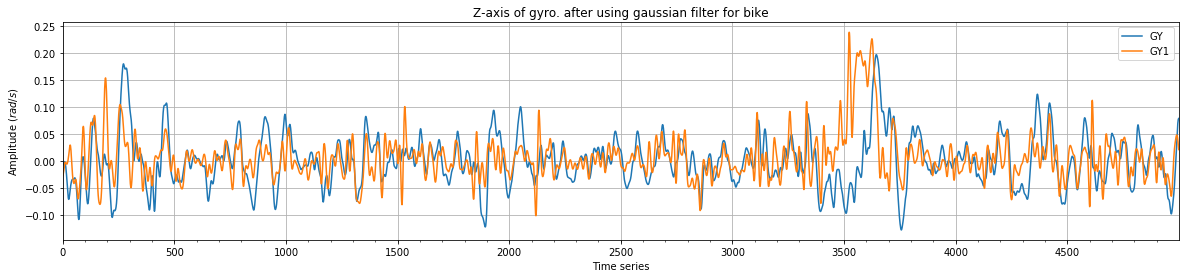

In [12]:
fig, ax = plt.subplots()
m=5000
df[['AZ' ,'AZ1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)

fig, ax = plt.subplots()
df[['GZ', 'GZ1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)


plt.grid(True)
fig, ax = plt.subplots()
df[['GX', 'GX1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)


plt.grid(True)
fig, ax = plt.subplots()
df[['GY', 'GY1']][0:m].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df[0:m])
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)


plt.grid(True)



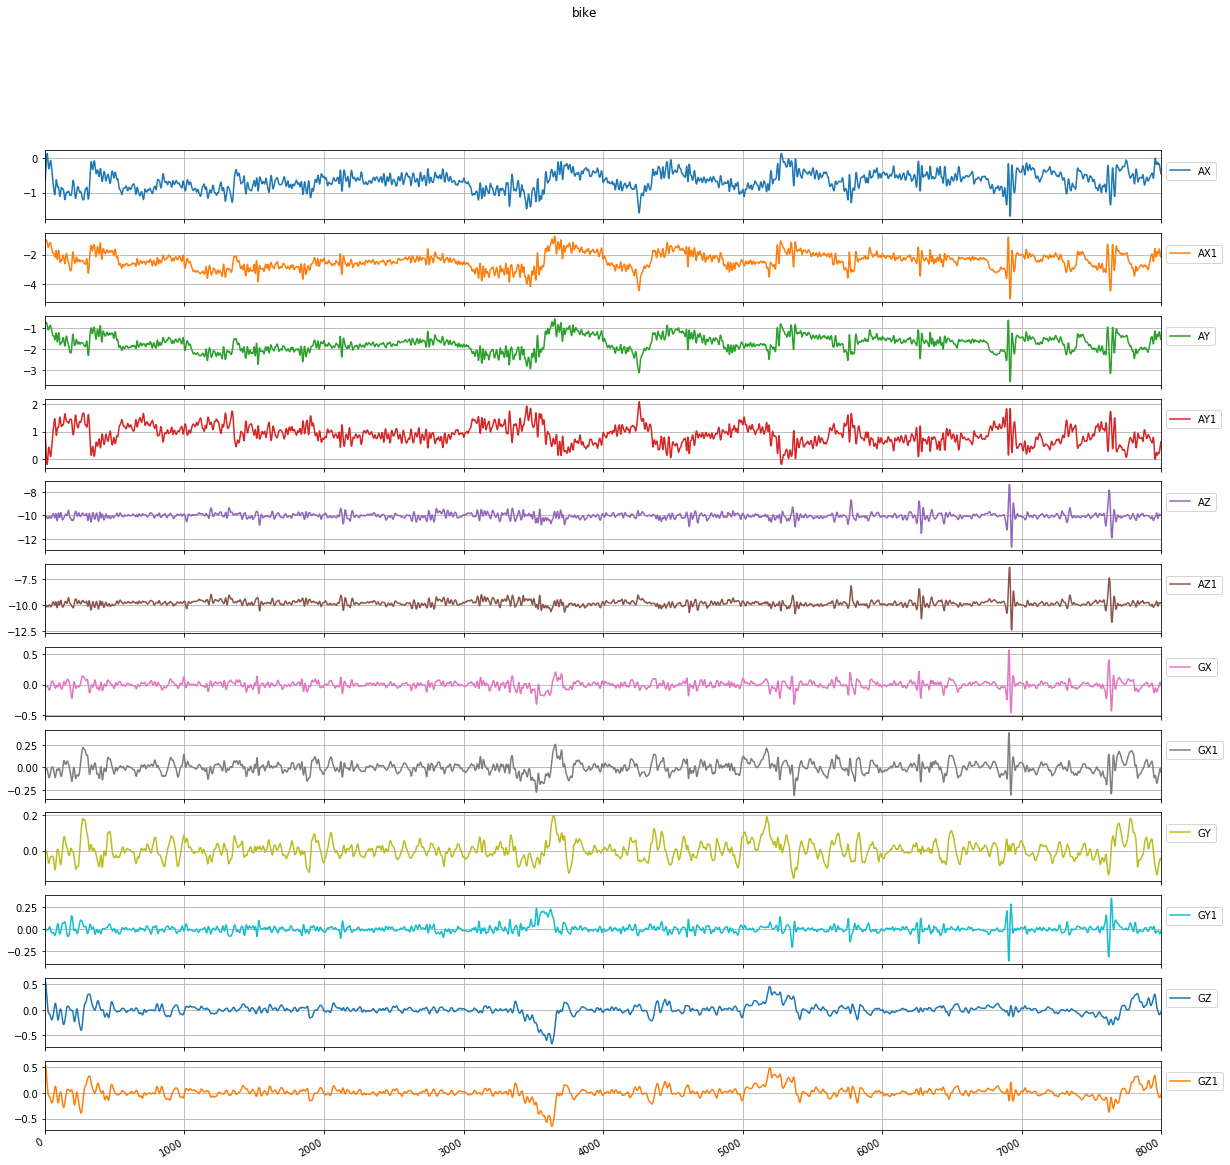

In [13]:
plot_transportation_mod('bike',df)